导包

In [14]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


配置环境和超参

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 1
num_workers = 0
lr_rate = 1e-4
num_epochs = 100


数据读入和加载

In [16]:
"""
两种方式
1.下载并使用PyTorch提供的内置数据集
2.从网站下载以csv格式存储的数据，读入并转成预期的格式
torchvision包可以方便对图像数据进行处理变换,需要将数据格式转为Tensor类
"""
from torchvision import transforms

image_size = 28
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# 采用自行构建Dataset类的方式
class FMDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.images = df.iloc[:, 1:].values.astype(np.uint8)
        self.labels = df.iloc[:, 0].values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28, 1)
        label = int(self.labels[idx])
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = torch.tensor(image/255.,dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

train_df = pd.read_csv("/home/zcx/Data/work/pytorch/data/fashion-mnist_train.csv")
test_df = pd.read_csv("/home/zcx/Data/work/pytorch/data/fashion-mnist_test.csv")
train_dataset = FMDataset(train_df, transform=data_transform)
test_dataset = FMDataset(test_df, transform=data_transform)


In [17]:
# 定义DataLoader类，以便在训练和测试时加载数据
train_loader = DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,num_workers=num_workers)

Image shape: torch.Size([1, 1, 28, 28])
Label shape: torch.Size([1])


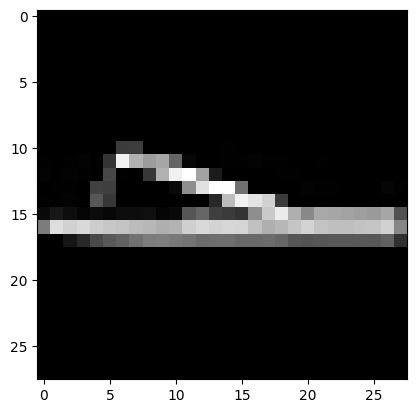

In [23]:
# 做一些数据可视化操作，主要是验证我们读入的数据是否正确
image, label = next(iter(train_loader))
print("Image shape:", image.shape)
print("Label shape:", label.shape)
plt.imshow(image[0][0], cmap='gray')


手搭CNN

In [24]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64 * 4 * 4)  # 展平
        x = self.fc(x)
        return x

model = Net().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

训练测试和验证

In [25]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
    train_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}')

def val(epoch):
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            preds = torch.argmax(output, dim=1)
            gt_labels.append(target.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, target)
            val_loss += loss.item()*data.size(0)
    val_loss /= len(test_loader.dataset)
    gt_labels = np.concatenate(gt_labels)
    pred_labels = np.concatenate(pred_labels)
    accuracy = np.mean(gt_labels == pred_labels)
    print(f'Epoch {epoch}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

In [ ]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    val(epoch)

# 保存模型
model_path = "/home/zcx/Data/work/pytorch/model/fashion_mnist/fashion_mnist_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Epoch 1, Train Loss: 0.5064
Epoch 1, Val Loss: 0.3402, Accuracy: 0.8754
Epoch 2, Train Loss: 0.3457
Epoch 2, Val Loss: 0.2881, Accuracy: 0.8923
Epoch 3, Train Loss: 0.3054
Epoch 3, Val Loss: 0.2649, Accuracy: 0.9007
Epoch 4, Train Loss: 0.2849
Epoch 4, Val Loss: 0.2459, Accuracy: 0.9079
Epoch 5, Train Loss: 0.2690
Epoch 5, Val Loss: 0.2437, Accuracy: 0.9093
Epoch 6, Train Loss: 0.2591
Epoch 6, Val Loss: 0.2414, Accuracy: 0.9158
Epoch 7, Train Loss: 0.2498
Epoch 7, Val Loss: 0.2340, Accuracy: 0.9109
Epoch 8, Train Loss: 0.2433
Epoch 8, Val Loss: 0.2595, Accuracy: 0.9089
Epoch 9, Train Loss: 0.2387
Epoch 9, Val Loss: 0.2438, Accuracy: 0.9130
Epoch 10, Train Loss: 0.2310
Epoch 10, Val Loss: 0.2335, Accuracy: 0.9152
Epoch 11, Train Loss: 0.2329
Epoch 11, Val Loss: 0.2301, Accuracy: 0.9197
Epoch 12, Train Loss: 0.2297
Epoch 12, Val Loss: 0.2317, Accuracy: 0.9176
Epoch 13, Train Loss: 0.2265
Epoch 13, Val Loss: 0.2316, Accuracy: 0.9192
Epoch 14, Train Loss: 0.2250
Epoch 14, Val Loss: 0.2293,